## MusicVAE

- magenta 패키지를 설치하는데 있어서 많은 어려움이 있었다.
- colab과 vscode에서도 설치하는데 문제가 생겨 4시간 정도를 고생하였다. 하지만 여러 stackflow에서 여러 글들을 보며 많은 것을 실천해볼 수 있었다.
- "llvmlite failed to install. Error building llvmlite" 문제를 결국 해결하였다. [해결방법]:https://stackoverflow.com/questions/65798319/llvmlite-failed-to-install-error-building-llvmlite
- 구글링을 하면서 pretty-midi 라는 것을 알게 되었는데 midi 파일을 다루기 위한 파이썬 라이브러리라고 한다. 추후에 더 공부해 볼 예정이다. [pretty-midi]: https://craffel.github.io/pretty-midi/

In [47]:
import warnings

warnings.filterwarnings("ignore")
from IPython.display import clear_output

In [48]:
import numpy as np
import os
import pandas as pd
import IPython
import collections

import note_seq #시퀀스 midi화 https://github.com/magenta/note-seq

import tensorflow._api.v2.compat.v1.compat.v1 as tf
tf.disable_v2_behavior()
from magenta.common import merge_hparams
from magenta.contrib import training as contrib_training
from magenta.models.music_vae import MusicVAE
from magenta.models.music_vae import lstm_models
from magenta.models.music_vae import data
from magenta.scripts.convert_dir_to_note_sequences import convert_directory #전처리
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel #훈련된모델

In [49]:
root_path = "C:/Users/nhw85/OneDrive/바탕 화면/MusicVAE"

In [50]:
midi_path = root_path +"/"+ "groove_midi"
print(os.listdir(midi_path))

['drummer1', 'drummer10', 'drummer2', 'drummer3', 'drummer4', 'drummer5', 'drummer6', 'drummer7', 'drummer8', 'drummer9', 'info.csv', 'LICENSE', 'README']


## Read Data & EDA

In [51]:
import pandas as pd

G_md = pd.read_csv(midi_path+'/'+'info.csv')
G_md.head()

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test


In [52]:
# train, validation, test 파일의 각각의 개수 

number_of_midis = {}

for i in G_md["split"].unique():
    number_of_midis[i] = len(G_md[G_md['split']==i])

number_of_midis

{'test': 129, 'train': 897, 'validation': 124}

In [53]:
# 장르의 종류와 수 

genre_counts = {}
genre = []
for st in G_md['style']:
    np_genre = st.split('/')[0]
    if np_genre not in genre_counts:
        genre_counts[np_genre] = 1
    else:
        genre_counts[np_genre] += 1
    if np_genre not in genre:
        genre.append(np_genre)


print("genre:", genre)
print("number_of_genre:", len(genre))

print('-'*100)

total_genre_count = sum(genre_counts.values()) # 전체 장르 수 계산

genre_ratios = {} # 장르 별 비율을 저장할 딕셔너리 생성

for genre, count in genre_counts.items():
    ratio = count / total_genre_count
    genre_ratios[genre] = ratio

print("Genre Ratios:")
for genre, ratio in genre_ratios.items():
    print(genre + ":", ratio)

genre: ['funk', 'soul', 'hiphop', 'pop', 'rock', 'jazz', 'neworleans', 'dance', 'latin', 'afrocuban', 'reggae', 'country', 'gospel', 'punk', 'afrobeat', 'blues', 'middleeastern', 'highlife']
number_of_genre: 18
----------------------------------------------------------------------------------------------------
Genre Ratios:
funk: 0.1391304347826087
soul: 0.05478260869565217
hiphop: 0.08260869565217391
pop: 0.023478260869565216
rock: 0.2965217391304348
jazz: 0.08782608695652173
neworleans: 0.04608695652173913
dance: 0.00608695652173913
latin: 0.08434782608695653
afrocuban: 0.05217391304347826
reggae: 0.017391304347826087
country: 0.025217391304347827
gospel: 0.01652173913043478
punk: 0.050434782608695654
afrobeat: 0.011304347826086957
blues: 0.0034782608695652175
middleeastern: 0.0008695652173913044
highlife: 0.0017391304347826088


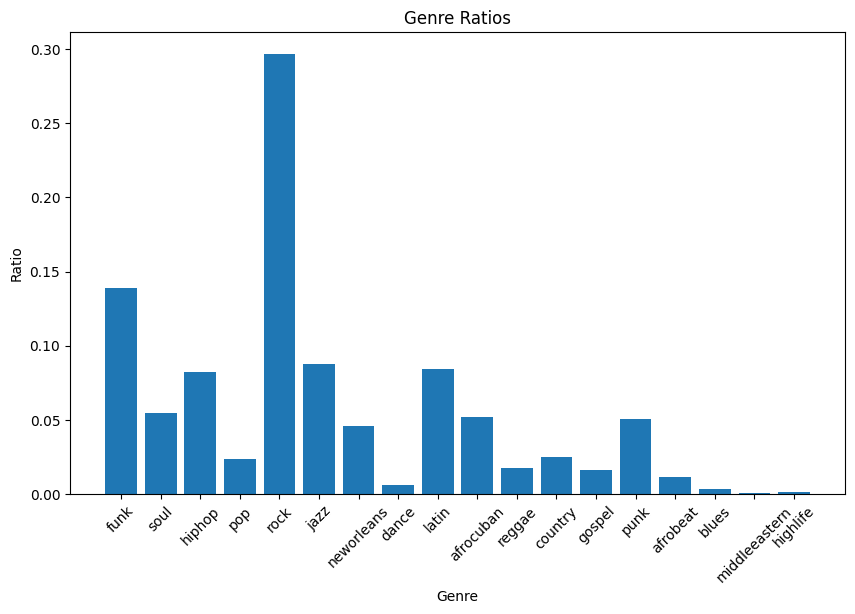

In [54]:
# 장르별 비율 시각화
# rock이 제일 높은 비율을 차지하고 있다.

import matplotlib.pyplot as plt

genres = list(genre_ratios.keys())
ratios = list(genre_ratios.values())

plt.figure(figsize=(10, 6))
plt.bar(genres, ratios)
plt.xlabel('Genre')
plt.ylabel('Ratio')
plt.title('Genre Ratios')
plt.xticks(rotation=45)
plt.show()

In [55]:
ts_unique = []
uncommon = []
cnt = 0
for idx, ts in enumerate(G_md['time_signature']):
    if ts not in ts_unique:
        ts_unique.append(ts)
    if ts != "4-4":
        cnt += 1
        if ts not in uncommon:
            uncommon.append(ts)
        

print("uncommon:", uncommon)
print("uncommon의 개수:",cnt)

uncommon: ['3-4', '5-4', '5-8', '6-8']
uncommon의 개수: 12



- bpm의 속도가 특정 장르와 상관 관계가 있는지 분석할 예정
- duration의 평균길이를 구하고, 마찬가지로 duration이 특정 장르나 특정 드러머와 상관관계가 있는지 분석할 예정

## 전처리: Preprocessing / MIDI2Record


- 여기서 에러가 초반에 또 생김. [에러명]: KeyError: "Registering two gradient with name 'BlockLSTM'!
- stack overflow, googling 을 통해 문제점을 발견, magenta가 요구하는 tensorflow의 버전과 달랐기에 문제가 발생, 무턱대고 tensorflow의 버전을 바꾸는 것이 아니라 anaconda python.ver 도 고려해야 함

- Train을 하기 위해서 데이터는 tfrecord 형식으로 저장이 되어야 한다.
    1. tfrecord 란 무엇인가?

        - tensorflow의 학습 데이터등을 저장하기 위한 바이너리 데이    터 포맷으로, 구글의  Protocol Buffer 포맷으로 데이터를 파일에 Serialize하여 저장한다.

    2. tfrecord 파일의 필요성

        - 이미지 데이터와 같은 데이터는 메타데이터와 레이블이 별도의 파일로 저장되어 있기 때문에, 각각 읽어들여야 해서 코드가 복잡해진다. ⇒ tfrecord 파일을 이용하면 훨씬 간단하게 해결 가능

        - 또한 이미지를 JPG나 PNG 포맷으로 읽어서 매번 디코딩을 하게 되면, 성능이 저하 됨

    - Refernces
        - https://nlp.gitbook.io/book/

In [56]:
import warnings
warnings.filterwarnings("ignore")

from magenta.scripts.convert_dir_to_note_sequences import convert_directory

tfrec_file = root_path+'/'+'midi.tfrecord'
convert_directory(midi_path, tfrec_file, recursive=True)
clear_output()

In [57]:
# music_vae/configs.py


#configs.py 스크립트 일부 발췌

class Config(collections.namedtuple(
    'Config',
    ['model', 'hparams', 'note_sequence_augmenter', 'data_converter',
     'train_examples_path', 'eval_examples_path', 'tfds_name'])):

    def values(self):
        return self._asdict()

Config.__new__.__defaults__ = (None,) * len(Config._fields)


def update_config(config, update_dict):
    config_dict = config.values()
    config_dict.update(update_dict)
    return Config(**config_dict)


CONFIG_MAP = {}


HParams = contrib_training.HParams

# 모델 config configs.py의 groovae config 사용

CONFIG_MAP['groovae_4bar'] = Config(
    model=MusicVAE(lstm_models.BidirectionalLstmEncoder(),
                   lstm_models.GrooveLstmDecoder()), # Groove LSTM decoder with MSE loss for continuous values.
    hparams=merge_hparams(
        lstm_models.get_default_hparams(),
        HParams(
            batch_size=512,
            max_seq_len=16 * 4,  # 4 bars w/ 16 steps per bar, 4마디, 16분음표 스텝으로 한마디 구성
            z_size=256,
            enc_rnn_size=[512],
            dec_rnn_size=[256, 256],
            max_beta=0.2,
            free_bits=48,
            dropout_keep_prob=0.3,
        )),
    note_sequence_augmenter=None,
    data_converter=data.GrooveConverter(
        split_bars=4, steps_per_quarter=4, quarters_per_bar=4,
        max_tensors_per_notesequence=20,
        pitch_classes=data.ROLAND_DRUM_PITCH_CLASSES,
        inference_pitch_classes=data.REDUCED_DRUM_PITCH_CLASSES),
    train_examples_path= root_path+'/'+"midi.tfrecord") 

In [59]:
# magenta/models/music_vae/music_vae_train.py
import tf_slim

# Should not be called from within the graph to avoid redundant summaries.
def _trial_summary(hparams, examples_path, output_dir): # 텐서보드에 표시될 텍스트 요약을 생성하는 함수

    examples_path_summary = tf.summary.text(
      'examples_path', tf.constant(examples_path, name='examples_path'),
      collections=[])

    hparams_dict = hparams.values()

    # Create a markdown table from hparams.
    header = '| Key | Value |\n| :--- | :--- |\n'
    keys = sorted(hparams_dict.keys())
    lines = ['| %s | %s |' % (key, str(hparams_dict[key])) for key in keys]
    hparams_table = header + '\n'.join(lines) + '\n'

    hparam_summary = tf.summary.text(
      'hparams', tf.constant(hparams_table, name='hparams'), collections=[])

    with tf.Session() as sess:
        writer = tf.summary.FileWriter(output_dir, graph=sess.graph)
        writer.add_summary(examples_path_summary.eval())
        writer.add_summary(hparam_summary.eval())
        writer.close()


In [60]:
def _get_input_tensors(dataset, config):
  # 데이터로부터 텐서 입력 
    batch_size = config.hparams.batch_size
    iterator = tf.data.make_one_shot_iterator(dataset)
    (input_sequence, output_sequence, control_sequence,
    sequence_length) = iterator.get_next() # 반환되는 값은 듀플형식
    input_sequence.set_shape(
    [batch_size, None, config.data_converter.input_depth])
    output_sequence.set_shape(
    [batch_size, None, config.data_converter.output_depth])
    
    if not config.data_converter.control_depth:
        control_sequence = None
    
    else:
        control_sequence.set_shape(
            [batch_size, None, config.data_converter.control_depth])
        sequence_length.set_shape([batch_size] + sequence_length.shape[1:].as_list())
        
    return {
        'input_sequence': input_sequence,
        'output_sequence': output_sequence,
        'control_sequence': control_sequence,
        'sequence_length': sequence_length
    }

In [61]:
# 훈련 체크포인트, 시간 설정
def train(train_dir,
          config,
          dataset_fn,
          checkpoints_to_keep=5,
          keep_checkpoint_every_n_hours=1,
          num_steps=None,
          master='',
          num_sync_workers=0,
          num_ps_tasks=0,
          task=0):

# train loop 
    tf.gfile.MakeDirs(train_dir)
    is_chief = (task == 0)

    with tf.Graph().as_default():
        with tf.device(tf.train.replica_device_setter(
            num_ps_tasks, merge_devices=True)):
            
            model = config.model
            model.build(config.hparams,
                        config.data_converter.output_depth,
                        is_training=True)
            
            optimizer = model.train(**_get_input_tensors(dataset_fn(), config))

            hooks = []
            if num_sync_workers:
                optimizer = tf.train.SyncReplicasOptimizer(
                    optimizer,num_sync_workers)
                hooks.append(optimizer.make_session_run_hook(is_chief))

            grads, var_list = list(zip(*optimizer.compute_gradients(model.loss)))
            global_norm = tf.global_norm(grads)
            tf.summary.scalar('global_norm', global_norm)
            
            if config.hparams.clip_mode == 'value':
                g = config.hparams.grad_clip
                clipped_grads = [tf.clip_by_value(grad, -g, g) for grad in grads]
            elif config.hparams.clip_mode == 'global_norm':
                clipped_grads = tf.cond(
                    global_norm < config.hparams.grad_norm_clip_to_zero,
                    lambda: tf.clip_by_global_norm(  
                        grads, config.hparams.grad_clip, use_norm=global_norm)[0],
                    lambda: [tf.zeros(tf.shape(g)) for g in grads])
            else:
                raise ValueError(
                    'Unknown clip_mode: {}'.format(config.hparams.clip_mode))
            train_op = optimizer.apply_gradients(
                    list(zip(clipped_grads, var_list)),
                    global_step=model.global_step,
                    name='train_step')
            logging_dict = {'global_step': model.global_step,
                            'loss': model.loss}
            
            hooks.append(tf.train.LoggingTensorHook(logging_dict, every_n_iter=100))
            if num_steps:
                hooks.append(tf.train.StopAtStepHook(last_step=num_steps))
                
            scaffold = tf.train.Scaffold(
                saver=tf.train.Saver(
                    max_to_keep=checkpoints_to_keep,
                    keep_checkpoint_every_n_hours=keep_checkpoint_every_n_hours))
            
            tf_slim.training.train(
                train_op=train_op,
                logdir=train_dir,
                scaffold=scaffold,
                hooks=hooks,
                save_checkpoint_secs=60,
                master=master,
                is_chief=is_chief)

In [62]:
def run(config_map,
        tf_file_reader=tf.data.TFRecordDataset,
        file_reader=tf.python_io.tf_record_iterator,
        is_training=True):
    
    config = config_map['groovae_4bar']
    train_dir = root_path+'/'+'train'
    num_steps = 1000
    
    def dataset_fn():
        return data.get_dataset(
            config,
            tf_file_reader=tf_file_reader,
            is_training=True,
            cache_dataset=True)
    
    if is_training == True:
        train(
            train_dir,
            config=config,
            dataset_fn=dataset_fn,
            num_steps=num_steps)      
    
    else:
        print("evaluation")

## 학습: Train

In [63]:
import warnings
warnings.filterwarnings("ignore")

run(CONFIG_MAP) # epoch 1000

INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, GrooveLstmDecoder, and hparams:
{'max_seq_len': 64, 'z_size': 256, 'free_bits': 48, 'max_beta': 0.2, 'beta_rate': 0.0, 'batch_size': 512, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [256, 256], 'enc_rnn_size': [512], 'dropout_keep_prob': 0.3, 'sampling_schedule': 'constant', 'sampling_rate': 0.0, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [512]

INFO:tensorflow:
Decoder Cells:
  units: [256, 256]

INFO:tensorflow:Reading examples from file: C:/Users/nhw85/OneDrive/바탕 화면/MusicVAE/midi.tfrecord
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_i

## 생성 : Generating

In [78]:
# music_vae_generate.py

from magenta.models.music_vae.trained_model import TrainedModel
import note_seq


model = TrainedModel(
    config=CONFIG_MAP['groovae_4bar'],
    batch_size=1,
    checkpoint_dir_or_path=root_path+'/train') # checkpoint path

# 4마디 샘플을 생성
generated_sequence = model.sample(n=10, length=16*4, temperature=0.5)
for idx,sample in enumerate(generated_sequence):
    note_seq.sequence_proto_to_midi_file(sample, root_path +'/generated_midi/{}_groovae_4-4_sample.mid'.format(idx))

INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, GrooveLstmDecoder, and hparams:
{'max_seq_len': 64, 'z_size': 256, 'free_bits': 48, 'max_beta': 0.2, 'beta_rate': 0.0, 'batch_size': 1, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [256, 256], 'enc_rnn_size': [512], 'dropout_keep_prob': 0.3, 'sampling_schedule': 'constant', 'sampling_rate': 0.0, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [512]

INFO:tensorflow:
Decoder Cells:
  units: [256, 256]



INFO:tensorflow:Restoring parameters from C:/Users/nhw85/OneDrive/바탕 화면/MusicVAE/train\model.ckpt-1000
